In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader 
import torchvision
from torchvision import transforms, utils

In [49]:
print("Torch version: {}".format(torch.__version__))
print("Torchvision version: {}".format(torchvision.__version__))

Torch version: 1.0.1
Torchvision version: 0.2.2


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

trainset = torchvision.datasets.CIFAR10(root='./datasets', train=True,
                                        transform=data_transforms['train'], download=True)
trainset_loader = DataLoader(trainset, batch_size=10, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/datasets', train=False,
                                      transform=data_transforms['test'], download=True)
testset_loader = DataLoader(testset, batch_size=10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def imshow(images):
    images = images / 2 + 0.5
    np_img = images.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

In [6]:
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

In [7]:
print('Images shape {}'.format(images.size()))
print('Labels shape {}'.format(labels.shape))

Images shape torch.Size([10, 3, 32, 32])
Labels shape torch.Size([10])


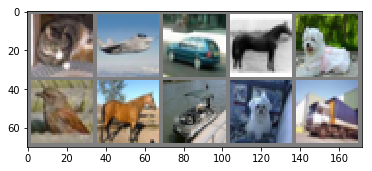

cat plane car horse dog bird horse ship dog truck


In [8]:
imshow(utils.make_grid(images, nrow=5))
print(' '.join('%s' % classes[labels[j]] for j in range(len(labels))))

In [10]:
import torch.nn as nn

In [11]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            # Input: (32x32x3)
            # Output (32x32x32)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # Output: (32x32x64)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Output: (16x16x64)
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer block2
            
            # Output: (16x16x128)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Output: (16x16x128)
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Output: (8x8x128)
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer block2
            
            # Output: (8x8x256)
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # Output: (8x8x256)
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Output: (4x4x256)
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            # 4096 = 4*4*256
            nn.Linear(in_features=4096, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=512, out_features=10)
        )
        
    def forward(self, x):
        
        x = self.conv_layer(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        x = self.fc_layer(x)
        
        return x

In [85]:
import time

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time() 
    
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}:\n".format(epoch+1, num_epochs))
        
        # Each epoch has a train and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                # Set model to training mode
                model = model.train()
            else:
                # Set model to evaluate mode
                model = model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for _, data in enumerate(dataloaders[phase]):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                # Trach history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, predicted = torch.max(outputs, 1)
                    
                    # Backward + optimize if only in train
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predicted == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print("{} Loss: {:.4f} | Accuracy: {:.4f}\n".format(phase, epoch_loss, epoch_acc))
            
            # Update accuracy history
            if phase == "train":
                train_acc_history.append(epoch_acc)
            elif phase == "val":
                val_acc_history.append(epoch_acc)
                
            
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    
    return model, train_acc_history, val_acc_history

In [86]:
# Initialize Net
net = CNN()
print(net)

# Net's parameters
params = list(net.parameters())
print(len(params))
# Conv2d's (0) weights
print(params[0].size())

# Parameters for training
start_epoch = 0
num_epochs = 5

# Dataloaders for training and validation phases
dataloaders_dict = {
    "train": trainset_loader,
    "val": testset_loader
}

from torch import optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), 0.001)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace)
    (15): Conv2d(256, 256, kern

In [87]:
# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [88]:
# Send the model to device
net = net.to(device)

net = train_model(net, dataloaders_dict, criterion, optimizer, num_epochs)

Epoch 1/5:



KeyboardInterrupt: 

In [67]:
inputs, labels = dataloaders_dict["train"]
print(labels.size())

ValueError: too many values to unpack (expected 2)